<a href="https://colab.research.google.com/github/sallyhu-seas/NYC-airbnb/blob/main/Airbnbs_What_Makes_Them_Successful%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to our City!

You're planning a trip to New York City and Los Angeles, and you're looking for a place to stay, but you're not sure where to begin. You might have a specific budget, you might want to walk everywhere, you might need robust WiFi, who knows! Only you do.

You peruse the Internet a little longer and, there it is: the two most perfect Airbnbs, one in each city. The prices are perfect, the locations are perfect, and one even has a hot tub and the other has a stunning rooftop view! Booked.

How did the hosts of your chosen Airbnbs know what you wanted? There's no way every visitor has the same needs as you, but the Airbnbs seemed perfect and had really high ratings!

In this project, we will analyze and assess the factors, both quantitative and qualitative, that make Airbnbs in NYC and LA successful. The analysis will center around two central themes:


*   ***Internal factors***: What makes an Airbnb appealing based on the listing? What can a host say or post that would a visitor more inclined to choose their Airbnb? Is it the amenities? How about the description of the listing? Maybe they need to respond to requests faster?
*   ***External factors***: We specifically chose NYC and LA because these vibrant cities are popular destinations for vistors of all backgrounds and they are diverse in every sense of the word: socioeconomically, demographically, culturally, etc. Consequently, we will analyze the impact of the city itself on the success of Airbnbs.


After analyzing the impact of these factors and more, we will predict the price and success of future listings, and recommend measures hosts can take to attract more guests (like you!).

# Data Exploration and Preprocessing

First, we pinpointed the data that's relevant to our analysis. Our datasets will come from three main sources:


*   **[Inside Airbnb](http://insideairbnb.com/get-the-data.html)**: 
      * Listings: Contains all attributes associated with a given Airbnb listings in NYC and LA since 2008.
*   **[NYC OpenData](https://data.cityofnewyork.us/Public-Safety/NYC-crime/qb7u-rbmr)**: 
      * NYPD Complaint Data: Contains all valid felony, misdemeanor, and violation crimes reported to the NYC Police Department (NYPD) since 2017.
*   **[Citizens' Committee for Children](https://data.cccnewyork.org/data/download#0,8/66)**:
      * Income-Level Data: Contains NYC household median income data by neighborhood since 1900. This data is filtered to keep only data from 2010 and after.



We will explore and preprocess each dataset in this section.

In [ ]:
!pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-cp36-none-any.whl size=26819 sha256=33ef05e475cde8eece6626fb258175f53e17c611367bdbcc382729a668c15108
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as ps

import zipfile
from google.colab import drive

import re
import nltk
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords, names, words
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('names')
nltk.download('words')

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import Counter

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
drive.mount('/content/drive/')
zip_ref = zipfile.ZipFile('/content/drive/Shared drives/CIS545: AirBnB/inside_airbnb.zip','r')
zip_ref.extractall('/content/sample_data')

Mounted at /content/drive/


## NYC and LA Airbnb Listings

### First Glance
The listings data provides us with so many attributes related to a given Airbnb listing in NYC and LA. First, we'll load the data from both cities and combine them.

In [ ]:
listings_nyc_df = pd.read_csv('/content/sample_data/Inside Airbnb/listings.csv')
listings_la_df = pd.read_csv('/content/drive/Shared drives/CIS545: AirBnB/Data/listings_la.csv')

In [ ]:
# Merge both cities into one dataset
listings_df = ps.sqldf('''
                        SELECT  *, 'NYC' as city
                        FROM    listings_nyc_df
                        UNION
                        SELECT  *, 'LA' as city
                        FROM    listings_la_df
                      ''')

In [ ]:
listings_df.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city
0,109,https://www.airbnb.com/rooms/109,2.020100e+13,10/25/2020,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...",None,https://a0.muscache.com/pictures/4321499/1da98...,521,https://www.airbnb.com/users/show/521,Paolo,6/27/2008,"San Francisco, California, United States","Paolo Privitera, CEO Evensi\n\nPaolo, MIT MBA ...",None,None,0%,f,https://a0.muscache.com/im/pictures/user/e704a...,https://a0.muscache.com/im/pictures/user/e704a...,Culver City,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,None,Culver City,Other Cities,33.98209,-118.38494,Entire condominium,Entire home/apt,6,None,2 baths,2.0,3.0,"[""TV"", ""Heating"", ""Cable TV"", ""Kitchen"", ""Sham...",$115.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,None,t,0,0,0,207,10/25/2020,2,0,0,8/15/2011,5/15/2016,80.0,10.0,10.0,6.0,8.0,10.0,8.0,None,f,1,1,0,0,0.02,LA
1,2595,https://www.airbnb.com/rooms/2595,2.020100e+13,10/7/2020,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,Jennifer,9/9/2008,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a day,70%,25%,f,https://a0.muscache.com/im/pictures/user/50fc5...,https://a0.muscache.com/im/pictures/user/50fc5...,Midtown,6.0,6.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"New York, United States",Midtown,Manhattan,40.75362,-73.98377,Entire apartment,Entire home/apt,2,None,1 bath,NaN,1.0,"[""Hot water"", ""Stove"", ""Extra pillows and blan...",$175.00,3,1125,3.0,3.0,1125.0,1125.0,3.0,1125.0,None,t,30,60,90,365,10/7/2020,48,1,0,11/21/2009,11/4/2019,94.0,9.0,9.0,10.0,10.0,10.0,9.0,None,f,2,2,0,0,0.36,NYC
2,2708,https://www.airbnb.com/rooms/2708,2.020100e+13,10/10/2020,Beautiful Furnish Mirrored Mini-Suite w/ Firep...,Beautiful Furnished Mirror Mini-Suite w/ Firep...,We are minutes away from the Mentor Language I...,https://a0.muscache.com/pictures/miso/Hosting-...,3008,https://www.airbnb.com/users/show/3008,Chas.,9/16/2008,"Los Angeles, California, United States",Writer.\r\nLiterary Manager.\r\nPhotographer.\...,within a few hours,100%,100%,t,https://a0.muscache.com/im/pictures/user/d17cf...,https://a0.muscache.com/im/pictures/user/d17cf...,Hollywood,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Los Angeles, California, United States",Hollywood,City of Los Angeles,34.09768,-118.34602,Private room in apartment,Private room,1,None,1.5 baths,1.0,1.0,"[""Bed linens"", ""Essentials"", ""Patio or balcony...",$75.00,30,366,30.0,30.0,1125.0,1125.

The data generally looks good, but we're not sure if it actually is. We want to take a full look at what is actually stored in this dataframe and what we might consider dropping.

At first glance, we already know certain columns must be preprocessed. For instance, we know from above that host_since is a date and host_response_rate is a percentage, but their types don't reflect that. Certainly price must be a number!

We also noticed that some columns are completely empty, like bathrooms and calendar_updated. These null columns can definitely be dropped. 

In [ ]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75199 entries, 0 to 75198
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            75199 non-null  int64  
 1   listing_url                                   75199 non-null  object 
 2   scrape_id                                     75199 non-null  float64
 3   last_scraped                                  75199 non-null  object 
 4   name                                          75181 non-null  object 
 5   description                                   72911 non-null  object 
 6   neighborhood_overview                         48167 non-null  object 
 7   picture_url                                   75199 non-null  object 
 8   host_id                                       75199 non-null  int64  
 9   host_url                                      75199 non-null 

### Basic Formatting
Before we begin exploring, we need to preprocess the most important parts of our data so that our exploration is meaningful. Our data must reflect the correct datatypes before we do anything else.

Judging from our initial look, these five columns should be dates. Let's update the type.

In [ ]:
listings_df['host_since']=listings_df['host_since'].apply(lambda x: pd.to_datetime(x,infer_datetime_format=True))
listings_df['first_review']=listings_df['first_review'].apply(lambda x: pd.to_datetime(x,infer_datetime_format=True))
listings_df['last_review']=listings_df['last_review'].apply(lambda x: pd.to_datetime(x,infer_datetime_format=True))
listings_df['last_scraped']=listings_df['last_scraped'].apply(lambda x: pd.to_datetime(x,infer_datetime_format=True))
listings_df['calendar_last_scraped']=listings_df['calendar_last_scraped'].apply(lambda x: pd.to_datetime(x,infer_datetime_format=True))

These columns should also be float types so let's cast them as such.

In [ ]:
listings_df['host_response_rate']=listings_df['host_response_rate'].apply(lambda x: str(x).replace('%','') if not x else x)
listings_df['host_acceptance_rate']=listings_df['host_acceptance_rate'].apply(lambda x: str(x).replace('%','') if not x else x)
listings_df['price']=listings_df['price'].apply(lambda x: float(str(x).replace('$','').replace(',','')))

In [ ]:
# We had to break this out and process the float type separately.
listings_df['host_response_rate']=listings_df['host_response_rate'].apply(lambda x: float(x) if not x else x)
listings_df['host_acceptance_rate']=listings_df['host_acceptance_rate'].apply(lambda x: float(x) if not x else x)

The listings data is officially ready to be explored. Let's take a look and see what we have. After our initial exploration, we'll finish preparing our dataset.

### Let's Explore!

Now we're going to poke around to learn about the data and also see if there's anything particularly striking. Our aim in this step is to find out what might be useful in our analysis and for our models, but also what can be thrown away.

This is our main dataset, so we explored and vetted it as thoroughly as possible.

#### **What to do with these?**

We'll take a closer look at the data and determine what is and isn't important to *our* analysis. During our exploration, we realize that a lot of attributes are interesting, but may not be necessarily relevant for our purposes. 

Note: Any and all final formatting efforts will be done in the *Final Cleaning and Formatting* section.

##### *Null Host Names?*

First, we noticed that there are 27 host names that are missing. After looking at the data, we saw that a lot of other information important to our analysis, such as ratings, are null. Since there are so few, we concluded that we can drop these without impacting our analysis.

In [ ]:
listings_df[listings_df['host_name'].isna() == True]['id'].count()

27

In [ ]:
# Take a peek at the 27
listings_df[listings_df['host_name'].isna() == True]

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city
7247,4446862,https://www.airbnb.com/rooms/4446862,2.020100e+13,2020-10-06,Charming Room in Prospect Heights!,Quiet room in three bedroom apt in Prospect He...,This charming Brooklyn neighborhood offers man...,https://a0.muscache.com/pictures/57579076/ace3...,23077718,https://www.airbnb.com/users/show/23077718,None,NaT,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,"Brooklyn, New York, United States",Crown Heights,Brooklyn,40.67512,-73.96146,Private room in apartment,Private room,2,None,1 bath,1.0,1.0,"[""Essentials"", ""Heating"", ""Air conditioning"", ...",50.0,1,1125,1.0,1.0,1125.0,1125.0,1.0,1125.0,None,t,0,0,0,0,2020-10-06,0,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,f,1,0,1,0,NaN,NYC
7808,4763327,https://www.airbnb.com/rooms/4763327,2.020100e+13,2020-10-06,"Luxurious, best location, spa inc'l","Brand new luxurious boutique building, swimmin...","Quoting from Time Out Magazine: ""Williamsburg ...",https://a0.muscache.com/pictures/59917673/e733...,24576978,https://www.airbnb.com/users/show/24576978,None,NaT,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,"Brooklyn, New York, United States",Greenpoint,Brooklyn,40.72035,-73.95355,Entire apartment,Entire home/apt,4,None,1 bath,1.0,2.0,"[""Pool"", ""Cable TV"", ""Essentials"", ""Washer"", ""...",195.0,1,1125,1.0,2.0,1125.0,1125.0,1.0,1125.0,None,t,0,0,0,0,2020-10-06,1,0,0,2015-10-20,2015-10-20,80.0,8.0,10.0,10.0,8.0,10.0,8.0,None,f,1,1,0,0,0.02,NYC
9816,6360224,https://www.airbnb.com/rooms/6360224,2.020100e+13,2020-10-10,"Sunny, Private room in Bushwick","Spacious room, lots of light. New, clean build...",None,https://a0.muscache.com/pictures/87714659/5b7b...,33134899,https://www.airbnb.com/users/show/33134899,None,NaT,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,Bushwick,Brooklyn,40.70146,-73.92792,Private room in apartment,Private room,1,None,0 baths,1.0,1.0,"[""Carbon monoxide alarm"", ""Air conditioning"", ...",37.0,1,1125,1.0,1.0,1125.0,1125.0,1.0,1125.0,None,t,0,0,0,0,2020-10-10,1,0,0,2015-07-01,2015-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,f,1,0,1,0,0.02,NYC
10680,6900415,https://www.airbnb.com/rooms/6900415,2.020100e+13,2020-10-10,"Quiet, Cozy West LA House","A beautiful, quiet little house with a great b...",Walking distance to coffee shops and restauran...,https://a0.muscache.com/pictures/87362346/ebd8...,36159573,https://www.airbnb.com/users/show/36159573,None,NaT,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,"Los Angeles, California, United States",Mar Vista,City of Los Angeles,34.00105,-118.43665,Entire house,Entire home/apt,3,None,1 bath,1.0,2.0,"[""Essentials"", ""Wifi"", ""Wa

##### *'Host Listings Count' vs 'Host Total Listings Count'*

Looking at host_listings_count and host_total_listings_count, we figured these columns would be useful for our model. But what's the difference between the two? After checking, we confirmed that there are no differences between the two, so we will drop host_total_listings_count.

In [ ]:
listings_df[listings_df['host_listings_count'] != listings_df['host_total_listings_count']].dropna()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city


Now we'll take a look at what our data actually consists of.

#### **A Glance at All Airbnbs**

Here, we take a look at what Airbnbs look like in general.

##### *Time Frame*

Since we're going to be integrating our listings data with other sources, we need to see what time period we're working with.

In [ ]:
listings_df['year'] = listings_df['host_since'].apply(lambda x: x.year)
time_period=listings_df.groupby(['city','year']).count()
time_period.reset_index(inplace=True)

Airbnb was founded in August of 2008, so it makes sense that hosts began joining starting in 2008. However, it's very apparent that Airbnb really gained traction starting in 2010, which means that from that year on, guests will have many, many more options to choose from.

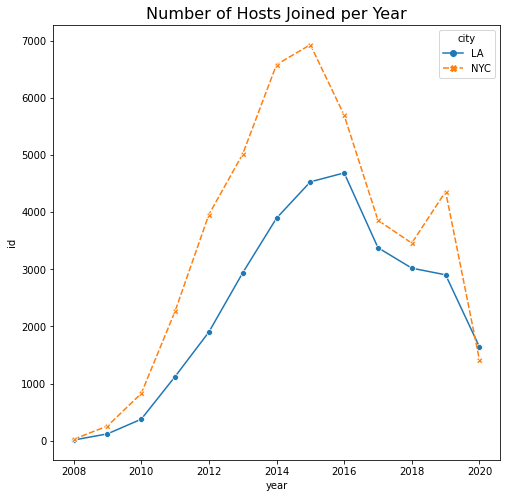

In [ ]:
plt.figure(figsize=(8,8))
sns.lineplot(data=time_period, x='year', y='id', hue='city', markers=True, style='city',ci=None)
plt.title('Number of Hosts Joined per Year', fontsize=16)
plt.show()

##### *Verified Hosts*

Surely all hosts should be verified? Looking at the numbers, it would appear not! More than 20% of all hosts across both cities are not verified. We wonder if this impacts people's decisions to stay at an Airbnb or not.

In [ ]:
ps.sqldf(
    '''
      WITH totals AS (
        SELECT  city
                ,count(id) AS total
        FROM    listings_df
        GROUP BY city
      )
      SELECT  l.city
              ,host_identity_verified
              ,count(id) as numVerified
              ,CAST(count(id) AS FLOAT) / CAST(total AS FLOAT) * 100 AS percentVerified
      FROM    listings_df l
              INNER JOIN totals t ON l.city = t.city
      GROUP BY l.city, host_identity_verified
    '''
)

,city,host_identity_verified,numVerified,percentVerified
0,LA,None,10,0.032751
1,LA,f,6117,20.034062
2,LA,t,24406,79.933187
3,NYC,None,17,0.038060
4,NYC,f,9914,22.195854
5,NYC,t,34735,77.766086


#### **Comparisons by City**

We now want to get a sense of what Airbnbs in each city look like compared to each other.

For comparisons of counts, the data is first standardized since we have more NYC data (approx. 45k listings) compared to LA data (approx. 30k listings).

##### *Room Types*

What are the most popular types of Airbnbs? Given the differences in cost of living and layout of each city, we can expect that there will be some differences.

In [ ]:
# First, we standardize.
room_type = listings_df.groupby(['city', 'room_type']).agg({'id': 'count'})
room_type = room_type.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
room_type.reset_index(inplace=True)

After plotting the proportions, we can see that the types of Airbnbs in each city are quite different from one another. While entire homes/apartments and private rooms are the most popular in both cities, a big majority of Airbnbs in LA are entire homes/apartments while in NYC, the types are more evenly split between entire homes/apartments and private rooms. 

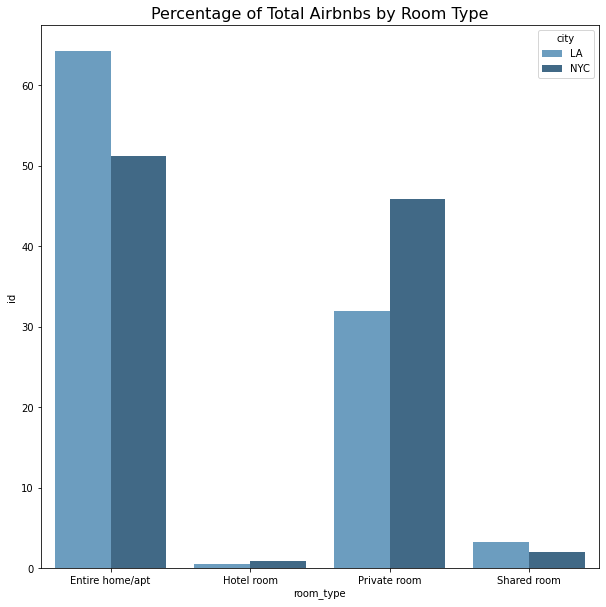

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,10))
sns.barplot(x='room_type', y='id', hue='city', data=room_type, palette='Blues_d')
plt.title('Percentage of Total Airbnbs by Room Type',fontsize=16)
plt.show()

##### *Host Response Times*

Do "West Coast vs East Coast" stereotypes hold? The general consensus is that West Coasters are generally more relaxed while East Coasters are more hurried. Do host response times reflect this stereotype? 

In [ ]:
# First, we standardize.
host_response_time = listings_df.groupby(['city', 'host_response_time']).agg({'id': 'count'})
host_response_time = host_response_time.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
host_response_time.reset_index(inplace=True)

It would appear not, but this is up to interpretation and speculation! We could assume that since West Coasters are more relaxed, they would respond to requests slower than their counterparts on the East Coast; however, this is clearly not the case since a big majority of them respond within an hour.

Another argument can be made that because West Coasters are so relaxed, they might have more time to attend to their personal affairs. Hopefully we can shed some light on this.

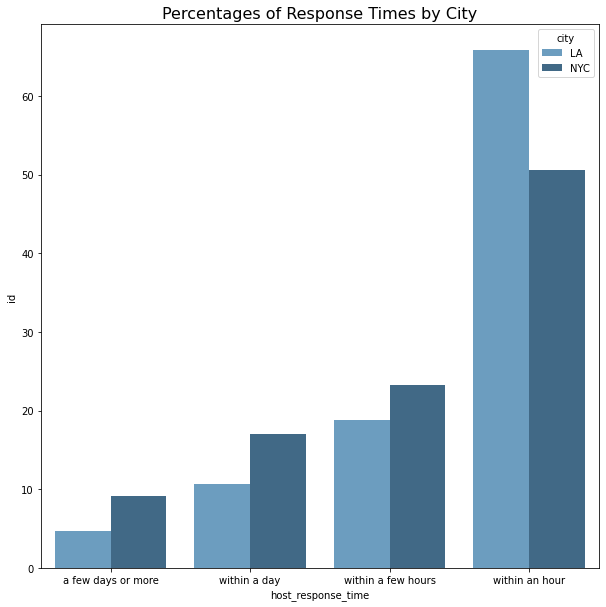

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,10))
sns.barplot(x='host_response_time', y='id', hue='city', data=host_response_time, palette='Blues_d')
plt.title('Percentages of Response Times by City',fontsize=16)
plt.show()

##### *Ratings from Reviews*

How to ratings stack up between the two cities? While ratings are generally high, which city comes out on top?

We'll take a look at the spread of ratings between the two and compare the plots with outliers (graph #1) and without (graph #2).

Since the average of the boxplot with outliers removed might be a little misleading, we calculated it first so we can directly compare the two cities. It seems that LA on average has better ratings than NYC.

In [ ]:
listings_df.groupby('city')['review_scores_rating'].mean()

city
LA     94.546277
NYC    93.849435
Name: review_scores_rating, dtype: float64

From the plot with outliers removed, we can also see that the distribution of reviews from LA is more narrow than NYC and spans across better ratings. Regardless, Airbnbs in both cities typically attain very high scores. But what about the outliers?

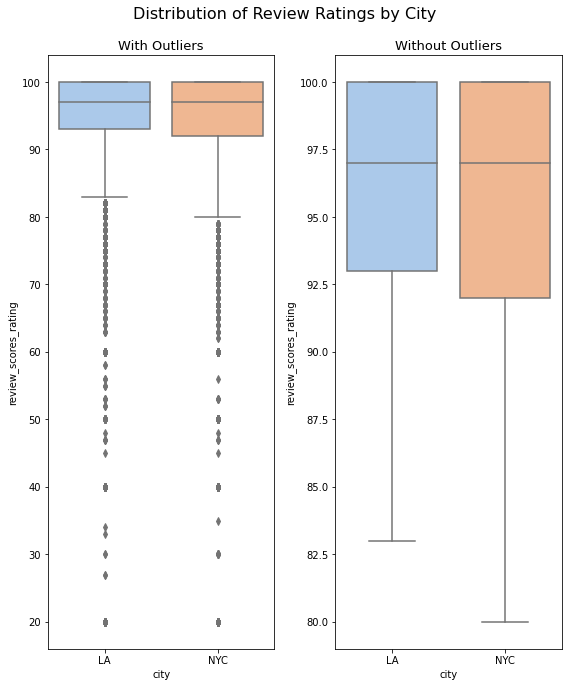

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,10))
sns.boxplot(x='city',y='review_scores_rating',data=listings_df,palette="pastel", ax=ax[0])
sns.boxplot(x='city',y='review_scores_rating',data=listings_df,palette="pastel", showfliers=False,ax=ax[1])
fig.suptitle('Distribution of Review Ratings by City',fontsize=16)
ax[0].set_title('With Outliers', fontsize=13)
ax[1].set_title('Without Outliers', fontsize=13)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()

##### *'Poorly' Rated Airbnbs*

Since we adjusted our previous analysis of the ratings because outliers skewed the picture, let's take a look and see what we can glean from them instead. Since the vast majority of ratings fall at 80% and above, we'll identify these "poorly"-rated Airbnbs as any Airbnb with a rating below 80%.

In [ ]:
# Sorted in order to standardize 'hue' assignment in graph
poor_ratings=listings_df[listings_df['review_scores_rating'] < 80].sort_values('city')
poor_reviews=poor_ratings[poor_ratings['number_of_reviews'] <= 25].sort_values('city')

Ratings are directly correlated to the number of reviews given. All the graphs display the relationship between the number of reviews an Airbnb receives and the corresponding rating. However, each graph is filtered as follows:

1.   Left-hand side: Includes all Airbnbs.
2.   Middle: Includes only Airbnbs with ratings less than 80%.
3.   Right-hand side: Includes only Airbnbs with ratings less than 80% and have 25 or fewer reviews.

Each graph progressively zooms in on more specific details.

As we can see, it's apparent that the vast majority of Airbnbs with "poor" ratings have just a handful of reviews, which would heavily impact the rating.

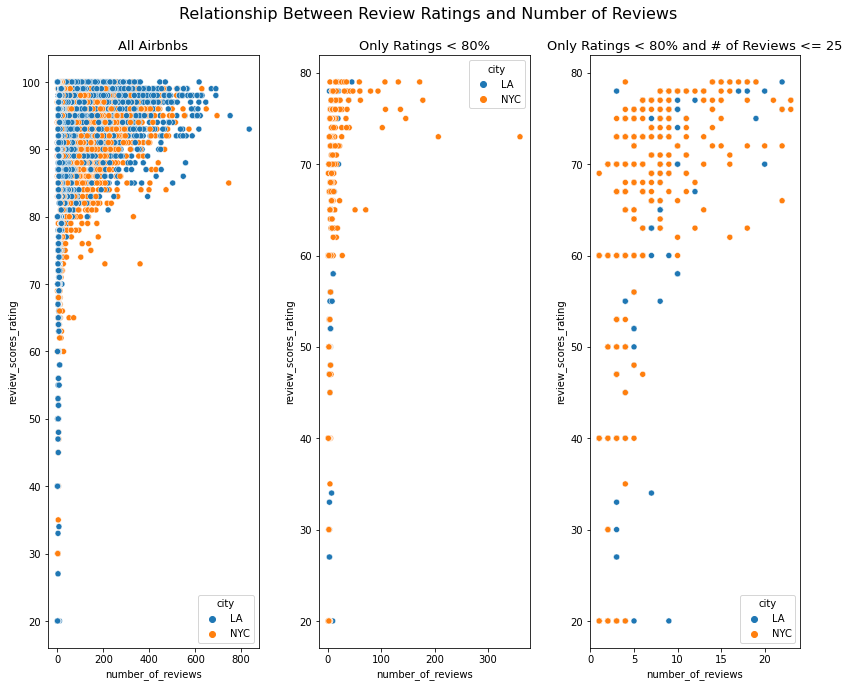

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,10))
sns.scatterplot(data=listings_df, x='number_of_reviews',y='review_scores_rating',hue='city',ax=ax[0])
sns.scatterplot(data=poor_ratings, x='number_of_reviews',y='review_scores_rating',hue='city',ax=ax[1])
sns.scatterplot(data=poor_reviews, x='number_of_reviews',y='review_scores_rating',hue='city',ax=ax[2])
fig.suptitle('Relationship Between Review Ratings and Number of Reviews',fontsize=16)
ax[0].set_title('All Airbnbs', fontsize=13)
ax[1].set_title('Only Ratings < 80%', fontsize=13)
ax[2].set_title('Only Ratings < 80% and # of Reviews <= 25', fontsize=13)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()

##### *Superhosts*

Airbnb defines superhosts as "experienced hosts who provide a shining example for other hosts, and extraordinary experiences for their guests" and they are identified with a badge on their profile.

Since this attribute is basically a direct measure of how great an Airbnb is, can this explain why LA Airbnbs seem to be outperforming NYC Airbnbs?

The answer is yes, this is entirely possible! Superhosts in LA make up about 32% of all hosts, whereas in NYC, they make up only about 18%.

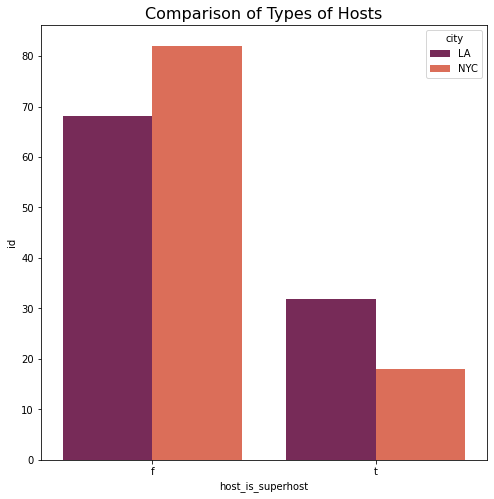

In [ ]:
# First, we standardize.
superhosts=listings_df.groupby(['city','host_is_superhost']).agg({'id': 'count'})
superhosts=superhosts.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
superhosts.reset_index(inplace=True)

fig, ax1 = plt.subplots(figsize=(8,8))
sns.barplot(x='host_is_superhost', y='id', hue='city', data=superhosts, palette='rocket')
plt.title('Comparison of Types of Hosts',fontsize=16)
plt.show()

### Final Cleaning and Formatting of Listings Data

Now that we have thoroughly explored the data, it's time to prepare it for our analyses.

#### Drop Null Host Names
From our initial analysis in *Null Host Names?*, we determined that we could drop these 27 null host names without impacting our analysis.

In [ ]:
listings_df.dropna(axis=0,subset={'host_name'},inplace=True)

#### Drop Irrelevant Columns

We have pinpointed the columns that are relevant for our purposes, so we can drop everything else.

In [ ]:
cols = pd.Series(listings_df.columns)

main_cols_drop = ['listing_url','scrape_id','last_scraped','picture_url','host_url','host_thumbnail_url',\
                  'host_picture_url','host_total_listings_count','host_verifications','neighbourhood','bathrooms',\
                  'calendar_updated', 'license','calendar_last_scraped','host_neighbourhood','year']

# Drop all columns about minimum night except for 'minimum_nights'
night_cols_drop = list(cols[cols.apply(lambda x: '_nights' in x)])[1:]

# Drop irrelevant availability columns
avail_cols_drop = list(cols[cols.apply(lambda x: 'availability' in x)])

# Drop all reviews count columns except for 'number_of_reviews'
review_cols_drop = list(cols[cols.apply(lambda x: 'number_of_reviews_' in x)])

# Drop host listing count by room type
listcount_cols_drop = list(cols[cols.apply(lambda x: 'calculated_host_listings_count' in x)])

# Other features to drop
other_cols_drop = ['property_type', 'bathrooms_text', 'last_review', 'instant_bookable', 'reviews_per_month', 'host_id']

drop_cols = main_cols_drop + night_cols_drop + avail_cols_drop + review_cols_drop + listcount_cols_drop + other_cols_drop

listings_df.drop(columns=drop_cols, inplace=True)

#### Booleans
For our model, we want Boolean features, but they need to be numeric. Let's cast them to zeroes and ones.

In [ ]:
listings_df['host_is_superhost']=listings_df['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)
listings_df['host_has_profile_pic']=listings_df['host_has_profile_pic'].apply(lambda x: 1 if x == 't' else 0)
listings_df['host_identity_verified']=listings_df['host_identity_verified'].apply(lambda x: 1 if x == 't' else 0)

#### Text Cleaning

Since our analysis also depends on qualitative features, we need to make sure that they are generally clean. In this section, we'll remove obviously bad patterns, such as HTML tags and escape characters.

In [ ]:
# Function to remove bad patterns
def remove_bad_patterns(text):
    h = re.compile("(<.*?>)")
    n = re.compile("\n")
    r = re.compile("\r")
    t = re.compile("\t")
    l = re.compile("\$")
    
    text = h.sub("",text)
    text = n.sub(" ",text)
    text = r.sub(" ",text)
    text = t.sub(" ",text)
    text = l.sub(" ",text)

    return text

In [ ]:
listings_df['description'] = listings_df['description'].apply(lambda x: remove_bad_patterns(str(x)))
listings_df['host_about'] = listings_df['host_about'].apply(lambda x: remove_bad_patterns(str(x)))
listings_df['neighborhood_overview'] = listings_df['neighborhood_overview'].apply(lambda x: remove_bad_patterns(str(x)))

In [ ]:
# Remove unclosed breaks at end of descriptions
listings_df['description'] = listings_df['description'].apply(lambda x: str(x).replace('<br','').replace('<br /','').replace('<b','').replace('</b','').replace('</',''))
listings_df['host_about'] = listings_df['host_about'].apply(lambda x: str(x).replace('<br','').replace('<br /','').replace('<b','').replace('</b','').replace('</',''))
listings_df['neighborhood_overview'] = listings_df['neighborhood_overview'].apply(lambda x: str(x).replace('<br','').replace('<br /','').replace('<b','').replace('</b','').replace('</',''))

In [ ]:
listings_df['description']=listings_df['description'].apply(lambda x: str(x).replace('<','') if str(x)[-1] == '<' else x)
listings_df['host_about']=listings_df['host_about'].apply(lambda x: str(x).replace('<','') if str(x)[-1] == '<' else x)
listings_df['neighborhood_overview']=listings_df['neighborhood_overview'].apply(lambda x: str(x).replace('<','') if str(x)[-1] == '<' else x)

#### Final Listings Data

Our listings data is now ready to be used in our analysis and in conjunction with the other sources.

In [ ]:
listings_df.head(5)

,id,name,description,neighborhood_overview,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,city
0,109,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...",None,Paolo,2008-06-27,"San Francisco, California, United States","Paolo Privitera, CEO Evensi Paolo, MIT MBA (P...",None,None,0%,0,1.0,1,1,Culver City,Other Cities,33.98209,-118.38494,Entire home/apt,6,2.0,3.0,"[""TV"", ""Heating"", ""Cable TV"", ""Kitchen"", ""Sham...",115.0,30,2,2011-08-15,80.0,10.0,10.0,6.0,8.0,10.0,8.0,LA
1,2595,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a day,70%,25%,0,6.0,1,1,Midtown,Manhattan,40.75362,-73.98377,Entire home/apt,2,NaN,1.0,"[""Hot water"", ""Stove"", ""Extra pillows and blan...",175.0,3,48,2009-11-21,94.0,9.0,9.0,10.0,10.0,10.0,9.0,NYC
2,2708,Beautiful Furnish Mirrored Mini-Suite w/ Firep...,Beautiful Furnished Mirror Mini-Suite w/ Firep...,We are minutes away from the Mentor Language I...,Chas.,2008-09-16,"Los Angeles, California, United States",Writer. Literary Manager. Photographer. Pro...,within a few hours,100%,100%,1,2.0,1,1,Hollywood,City of Los Angeles,34.09768,-118.34602,Private room,1,1.0,1.0,"[""Bed linens"", ""Essentials"", ""Patio or balcony...",75.0,30,27,2014-06-09,97.0,10.0,10.0,10.0,10.0,10.0,10.0,LA
3,2732,Zen Life at the Beach,An oasis of tranquility awaits you.The spaceTh...,"This is the best part of Santa Monica. Quiet, ...",Yoga Priestess,2008-09-17,"Santa Monica, California, United States",I have been teaching yoga and meditation for 3...,within an hour,92%,50%,0,2.0,1,1,Santa Monica,Other Cities,34.00475,-118.48127,Private room,1,1.0,1.0,"[""Hangers"", ""Refrigerator"", ""Dishes and silver...",155.0,1,21,2011-06-06,94.0,9.0,9.0,9.0,9.0,10.0,9.0,LA
4,2864,* Beautiful Master Suite/Jacuzzi Tub/*,Centrally located.... Furnished with King Size...,What makes the neighborhood unique is that the...,Bernadine,2008-09-25,"Bellflower, California, United States","Fair, open, honest and very informative for ne...",None,None,None,0,1.0,1,1,Bellflower,Other Cities,33.87619,-118.11397,Entire home/apt,2,1.0,1.0,"[""Bed linens"", ""Essentials"", ""TV"", ""Free stree...",50.0,30,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LA


## NYC and LA Crime Data

The goal of collecting and integrating NYC and LA crime data into the AirBnB listings data is to create a proxy for neighborhood safety. Crime level is a factor that hosts cannot control, but will impact their Airbnb nonetheless.

*Caveat*: The NYPD crime report data only provides borough/precinct-level identifier in each crime report. Given that there are 5 boroughs in total in NYC, we acknowledge neighborhoood characteristics could vary within a borough. However, this is the best information we could find so far that best represents safety in each region.  

### NYC Crime Data

In [ ]:
!unzip '/content/drive/Shareddrives/CIS545: AirBnB/NYPD_Complaint_Data_Historic.csv.zip'
crime_df_org = pd.read_csv('/content/NYPD_Complaint_Data_Historic.csv')

Archive:  /content/drive/Shareddrives/CIS545: AirBnB/NYPD_Complaint_Data_Historic.csv.zip
  inflating: NYPD_Complaint_Data_Historic.csv  
  inflating: __MACOSX/._NYPD_Complaint_Data_Historic.csv  


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### First Glance

Let's look at how the NYC crime data is broken down and see what might be relevant for our analysis.

The report is quite detailed, but we don't need such granular information. However, we can see that it does provide telling information such as when the report was filed, what kind and level of crime was committed and within which borough.

In [ ]:
crime_df_org.head(5)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,724718389,09/04/2014,17:25:00,09/04/2014,17:35:00,81.0,09/04/2014,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,COMPLETED,MISDEMEANOR,BROOKLYN,OPPOSITE OF,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1005945.0,188862.0,NaN,NaN,NaN,NaN,40.685041,-73.921777,"(40.685040958, -73.921776995)",PATROL BORO BKLYN NORTH,NaN,25-44,WHITE,F
1,191133903,10/12/2016,07:40:00,10/12/2016,07:45:00,121.0,10/12/2016,109,GRAND LARCENY,417.0,"LARCENY,GRAND FROM PERSON,PURS",COMPLETED,FELONY,STATEN ISLAND,NaN,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,947034.0,171375.0,UNKNOWN,BLACK,U,NaN,40.636991,-74.134093,"(40.63699139, -74.134092508)",PATROL BORO STATEN ISLAND,NaN,45-64,WHITE HISPANIC,F
2,720151206,09/28/2012,13:30:00,09/28/2012,14:00:00,41.0,10/19/2012,109,GRAND LARCENY,413.0,"LARCENY,GRAND BY FALSE PROMISE",COMPLETED,FELONY,BRONX,FRONT OF,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1014179.0,239453.0,NaN,WHITE HISPANIC,M,NaN,40.823876,-73.891863,"(40.823876276, -73.891862968)",PATROL BORO BRONX,NaN,45-64,WHITE HISPANIC,F
3,232242098,03/24/2015,15:45:00,NaN,NaN,46.0,03/24/2015,341,PETIT LARCENY,339.0,"LARCENY,PETIT FROM OPEN AREAS,",COMPLETED,MISDEMEANOR,BRONX,FRONT OF,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1009041.0,247401.0,NaN,BLACK,M,NaN,40.845707,-73.910398,"(40.845707148, -73.910398033)",PATROL BORO BRONX,NaN,<18,WHITE HISPANIC,F
4,708078702,05/20/2017,04:02:00,05/20/2017,04:09:00,109.0,05/20/2017,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,COMPLETED,MISDEMEANOR,QUEENS,FRONT OF,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1031779.0,217663.0,25-44,WHITE HISPANIC,M,NaN,40.763992,-73.828426,"(40.763991557, -73.828425559)",PATROL BORO QUEENS NORTH,NaN,25-44,BLACK,M


Let's see what the breakdown is. As usual, there will be some clean-up that needs to be done.

In [ ]:
crime_df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6983207 entries, 0 to 6983206
Data columns (total 35 columns):
 #   Column             Dtype  
---  ------             -----  
 0   CMPLNT_NUM         int64  
 1   CMPLNT_FR_DT       object 
 2   CMPLNT_FR_TM       object 
 3   CMPLNT_TO_DT       object 
 4   CMPLNT_TO_TM       object 
 5   ADDR_PCT_CD        float64
 6   RPT_DT             object 
 7   KY_CD              int64  
 8   OFNS_DESC          object 
 9   PD_CD              float64
 10  PD_DESC            object 
 11  CRM_ATPT_CPTD_CD   object 
 12  LAW_CAT_CD         object 
 13  BORO_NM            object 
 14  LOC_OF_OCCUR_DESC  object 
 15  PREM_TYP_DESC      object 
 16  JURIS_DESC         object 
 17  JURISDICTION_CODE  float64
 18  PARKS_NM           object 
 19  HADEVELOPT         object 
 20  HOUSING_PSA        object 
 21  X_COORD_CD         float64
 22  Y_COORD_CD         float64
 23  SUSP_AGE_GROUP     object 
 24  SUSP_RACE          object 
 25  SUSP_SEX          

#### Basic Formatting

Again, we need to preprocess the most important parts of our data to reflect the correct datatypes so that our exploration is meaningful.

First, we'll rename the columns to make them more descriptive and we'll only keep the columns of interest.

In [ ]:
crime_df = crime_df_org.rename(columns={'LAW_CAT_CD': 'offense_level', 'CRM_ATPT_CPTD_CD':'crime_completion', 'CMPLNT_FR_DT':'date', 'OFNS_DESC':'offense_desc', 'BORO_NM':'borough_name'})

In [ ]:
crime_df = crime_df[['date', 'borough_name', 'offense_level', 'offense_desc', 'crime_completion']]

Next, we'll update the 'date' column to actually be a date.

In [ ]:
def clean_date(date):
  if re.findall('(/10)[0-9]{2}$', date):
    y = re.findall('/10([0-9]{2})$', date)[0]
    return re.sub('/10[0-9]{2}', '/20'+y, date)
  return date
  
crime_df['date'] = crime_df['date'].apply(lambda x: clean_date(str(x)))
crime_df['date'] = pd.to_datetime(crime_df['date'], format='%m/%d/%Y')
crime_df['year'] = crime_df['date'].apply(lambda x: x.year)

Since the report holds data from since 1900, we need to filter the data for incidents more related to our timeframe, otherwise our analysis will be skewed based on a century's worth of data.

From our analysis of the listings data, we determined that the number of hosts that joined Airbnb significantly increased in 2010, which means that the number of Airbnbs that guests can choose from also dramatically increased around that time. As a result, we'll filter our data to only include incidents from 2010 to 2019 (pre-pandemic).

In [ ]:
crime_df_2010 = crime_df[(crime_df['year']>=2010) & (crime_df['year']<=2019)]

#### Let's Explore!

Let's get a sense of how crime is broken down in NYC.

In [ ]:
crime_borough = crime_df_2010.groupby(['year','borough_name','offense_level']).count()
crime_borough.reset_index(inplace=True)

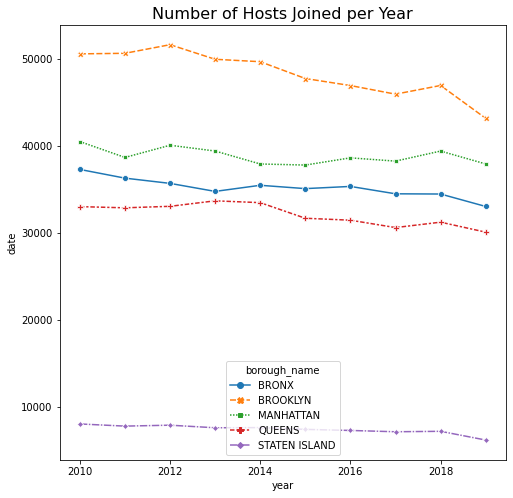

In [ ]:
plt.figure(figsize=(8,8))
sns.lineplot(data=crime_borough, x='year', y='date', hue='borough_name', markers=True, style='borough_name',ci=None)
plt.title('Number of Hosts Joined per Year', fontsize=16)
plt.show()

In [ ]:
crime_df['offense_level'].value_counts()

MISDEMEANOR    3938246
FELONY         2150008
VIOLATION       894953
Name: offense_level, dtype: int64

In [ ]:
crime_df['crime_completion'].value_counts()

COMPLETED    6863758
ATTEMPTED     119442
Name: crime_completion, dtype: int64

In [ ]:
crime_df['offense_desc'].value_counts()

PETIT LARCENY                      1165360
HARRASSMENT 2                       880644
ASSAULT 3 & RELATED OFFENSES        731300
CRIMINAL MISCHIEF & RELATED OF      699377
GRAND LARCENY                       607704
                                    ...   
FELONY SEX CRIMES                       10
ABORTION                                 7
OFFENSES AGAINST MARRIAGE UNCL           4
KIDNAPPING AND RELATED OFFENSES          3
UNDER THE INFLUENCE OF DRUGS             3
Name: offense_desc, Length: 71, dtype: int64

#### Final Cleaning and Formatting of NYC Crime Data

The most important data from this dataset as it relates to our Airbnb listings data is the number of crimes by borough. Therefore, we will pull a summary by year and borough to merge to our listings data.

In [ ]:
crime_df_summary = crime_df_2010.drop(columns=['date', 'offense_desc', 'offense_level']).groupby(['year', 'borough_name']).count()
crime_df_summary.reset_index(inplace=True)
crime_df_summary = crime_df_summary.rename(columns={'crime_completion': 'crime_count'})

Because the crime data is heavily skewed based on the population of a borough, we will normalize and calculate crime on a per capita basis instead.

We pulled the census population estimate by borough in 2019 from the [official Census website](https://www.census.gov/quickfacts/fact/table/newyorkcitynewyork,bronxcountybronxboroughnewyork,kingscountybrooklynboroughnewyork,newyorkcountymanhattanboroughnewyork,queenscountyqueensboroughnewyork,richmondcountystatenislandboroughnewyork/PST045219) and capture them here.


In [ ]:
nyc_pop_dict = {'borough':['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'], 'Population': [1418207, 2559903, 1628706, 2253858, 476143]}
nyc_pop = pd.DataFrame(nyc_pop_dict)

After normalizing the crime summary, our NYC crime data is now ready to be integrated with our listings data.

In [ ]:
crime_df_summary = crime_df_summary.merge(nyc_pop, left_on='borough_name', right_on='borough').drop(columns = 'borough')
crime_df_summary['crime_per_capita'] = crime_df_summary.crime_count/crime_df_summary.Population
crime_df_summary.drop(columns=['crime_count', 'Population'], inplace=True)

In [ ]:
crime_df_summary.head(5)

,year,borough_name,crime_per_capita
0,2010.0,BRONX,0.078807
1,2011.0,BRONX,0.076695
2,2012.0,BRONX,0.075423
3,2013.0,BRONX,0.073473
4,2014.0,BRONX,0.074958


### LA Crime Data

In [ ]:
la_crime = pd.read_csv('/content/drive/Shareddrives/CIS545: AirBnB/Data/la crime.csv')

#### First Glance and Formatting

The LA crime data we collected was already cleaned and processed. It contains data on crime per capita in each neighborhood, which cleanly maps to the LA neighborhoods in our listings data. Here, we'll just read it in and keep the relevant columns.

In [ ]:
la_crime.head(5)

,RANK,NEIGHBORHOOD,PER CAPITA,TOTAL
0,1,Chesterfield Square,126.9,81
1,2,Vermont Vista,122.9,306
2,3,Vermont Knolls,110.4,238
3,4,Harvard Park,109.3,119
4,5,Broadway-Manchester,105.4,272


In [ ]:
la_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RANK          209 non-null    int64  
 1   NEIGHBORHOOD  209 non-null    object 
 2   PER CAPITA    209 non-null    float64
 3   TOTAL         209 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 6.7+ KB


In [ ]:
la_crime = la_crime[['NEIGHBORHOOD', 'PER CAPITA']]
la_crime.columns = ['neighborhood', 'crime_per_capita']

In [ ]:
la_crime.head(5)

,neighborhood,crime_per_capita
0,Chesterfield Square,126.9
1,Vermont Vista,122.9
2,Vermont Knolls,110.4
3,Harvard Park,109.3
4,Broadway-Manchester,105.4


## NYC and LA Income Data

Similar to why we will use crime data in our analysis, we will also use NYC and LA income data to create a proxy for neighborhood affluence. This is also an external factor that hosts cannot control, but one that can affect visitors' perceptions and decisions. It may also enable the host to increase their price as the neighborhood affluence increases or force the host to decrease their price if it decreases.

We pull median income data instead of average because we want to eliminate biases in the figures. Especially in cities like NYC and LA, there could be a handful of extremely wealthy people in a given neighborhood that could inflate the average income and therefore be very misleading when used as a proxy for neighborhood affluence.

### NYC Income Data

In [ ]:
income_df_orig = pd.read_csv('/content/drive/Shareddrives/CIS545: AirBnB/Median Incomes.csv', skiprows=5)

#### First Glance

The data generally looks good already, but there's some preprocessing that still needs to be done.

In [ ]:
income_df_orig.head(5)

,Location,Household Type,TimeFrame,DataFormat,Data,Fips
0,Riverdale,All Households,2005,Dollars,63435.46009,208
1,Williamsbridge,All Households,2005,Dollars,52141.77239,212
2,Throgs Neck,All Households,2005,Dollars,57712.50261,210
3,Pelham Parkway,All Households,2005,Dollars,52782.17672,211
4,Morrisania,All Households,2005,Dollars,24589.9512,203


At the very least, the 'Data' column should be numeric so let's change that first before we explore...

In [ ]:
income_df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Location        3900 non-null   object
 1   Household Type  3900 non-null   object
 2   TimeFrame       3900 non-null   int64 
 3   DataFormat      3900 non-null   object
 4   Data            3900 non-null   object
 5   Fips            3900 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 182.9+ KB


... Whoops! We can't immediately change this to be numeric -- it looks like there's some invalid data. We'll poke through the other columns first to determine what needs to be kept or dropped before we handle these.

In [ ]:
income_df_orig[income_df_orig['Data'] == '#VALUE!']

,Location,Household Type,TimeFrame,DataFormat,Data,Fips
1706,Upper East Side,Families with Children,2011,Dollars,#VALUE!,108
2750,Murray Hill/Stuyvesant,Families with Children,2015,Dollars,#VALUE!,106
2752,Battery Park/Tribeca,Families with Children,2015,Dollars,#VALUE!,101
2753,Greenwich Village,Families with Children,2015,Dollars,#VALUE!,102


#### Let's Explore!

##### *Household Type*
What does "household type" constitute? From looking at the values, it looks like the dataset provides the median income of households of various types for a given neighborhood.

In [ ]:
income_df_orig['Household Type'].unique()

array(['All Households', 'Families', 'Families with Children',
       'Families without Children'], dtype=object)

In [ ]:
income_df_orig[(income_df_orig['Location'] == 'Upper East Side') & (income_df_orig['TimeFrame'] == 2015)]

,Location,Household Type,TimeFrame,DataFormat,Data,Fips
2616,Upper East Side,All Households,2015,Dollars,110557.62253,108
2681,Upper East Side,Families,2015,Dollars,217538.00946,108
2746,Upper East Side,Families with Children,2015,Dollars,248791.07051,108
2811,Upper East Side,Families without Children,2015,Dollars,207441.89596,108


Since we want to consider all households in a given neighborhood regardless of whether they are a family or not, we will filter our dataset for only 'All Households'.

##### *Other Attributes*

Let's glance at the other columns to see if they're anything particularly useful.

FIPS codes uniquely define a geographic area, but since we have neighborhood location, we won't need this information.

In [ ]:
income_df_orig['Fips'].unique()

array([    208,     212,     210,     211,     203,     206,     207,
           205,     204,     209,     201,     202,     112,     109,
           110,     111,     108,     107,     104,     105,     106,
           103,     101,     102,     503,     502,     501,     301,
           304,     303,     302,     306,     308,     316,     305,
           318,     317,     309,     307,     310,     312,     314,
           315,     311,     313,     401,     403,     407,     411,
           413,     408,     404,     406,     402,     405,     409,
           412,     410,     414,   36005,   36047,   36061,   36081,
         36085, 3651000])

All amounts are also in US Dollars, so we won't need the "DataFormat" column as well.

In [ ]:
income_df_orig['DataFormat'].unique()

array(['Dollars'], dtype=object)

Finally, looking at the years, we can see that this dataset does hold information relevant to our time period. To match this with our crime dataset, we will also filter this to retain data from 2010 and later.

In [ ]:
income_df_orig['TimeFrame'].unique()

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019])

#### Final Cleaning and Formatting of NYC Income Data

After the above analysis, we now know what we can safely drop and reformat.

First, we'll filter our dataset to keep only the median incomes of all households and only those from 2010 and later.

In [ ]:
income_df = income_df_orig[income_df_orig['Household Type']=='All Households']
income_df = income_df[income_df['TimeFrame']>=2010]

We also determined that the only columns of interest to us were location, year and income. Let's drop all the other columns.

In [ ]:
income_df = income_df.drop(columns=['Household Type', 'DataFormat', 'Fips'])

Finally, we'll rename the columns to be more descriptive and also change the datatype of income to be numeric.

In [ ]:
income_df.columns = ['neighborhood', 'year', 'income']
income_df.reset_index(drop=True, inplace=True)

income_df['income'] = income_df['income'].apply(lambda x: round(float(x)))

In [ ]:
income_df.head(5)

,neighborhood,year,income
0,Riverdale,2010,58804
1,Williamsbridge,2010,51674
2,Throgs Neck,2010,55497
3,Pelham Parkway,2010,51251
4,Morrisania,2010,24179


##### *Additional Exploration*

Now that our data is filtered and cleaned, we want to get a better understanding of what neighborhood dynamics are like between the 65 neighborhoods.

In [ ]:
income_df.neighborhood.unique()

array(['Riverdale', 'Williamsbridge', 'Throgs Neck', 'Pelham Parkway',
       'Morrisania', 'East Tremont', 'Bedford Park', 'University Heights',
       'Concourse/Highbridge', 'Unionport/Soundview', 'Mott Haven',
       'Hunts Point', 'Washington Heights', 'Manhattanville',
       'Central Harlem', 'East Harlem', 'Upper East Side',
       'Upper West Side', 'Chelsea/Clinton', 'Midtown Business District',
       'Murray Hill/Stuyvesant', 'Lower East Side',
       'Battery Park/Tribeca', 'Greenwich Village', 'Tottenville',
       'South Beach', 'St. George', 'Williamsburg/Greenpoint', 'Bushwick',
       'Bedford Stuyvesant', 'Fort Greene/Brooklyn Hts', 'Park Slope',
       'Crown Heights North', 'Brownsville', 'East New York', 'Canarsie',
       'East Flatbush', 'Crown Heights South', 'Sunset Park', 'Bay Ridge',
       'Borough Park', 'Flatbush/Midwood', 'Sheepshead Bay',
       'Bensonhurst', 'Coney Island', 'Astoria', 'Jackson Heights',
       'Flushing', 'Bayside', 'Queens Village', 

**Top 10 Neighborhoods**

Below are the top 10 neighborhoods with the highest median income as of 2019. 

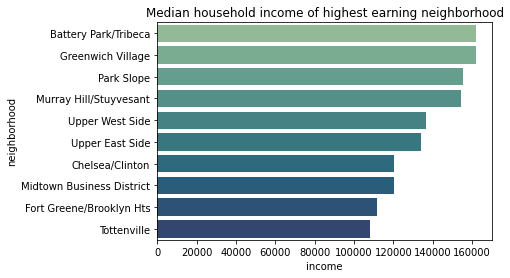

In [ ]:
top10neighborhood = income_df[income_df['year']==2019].sort_values(by='income', ascending=False, ignore_index=True).head(10)
sns.barplot(data=top10neighborhood, x='income',y='neighborhood', palette='crest').set_title('Median household income of highest earning neighborhood')
plt.show()

How has the median income changed over the past ten years for the top 10 neighborhoods? It seems like they have only gotten increasingly wealthier over time.

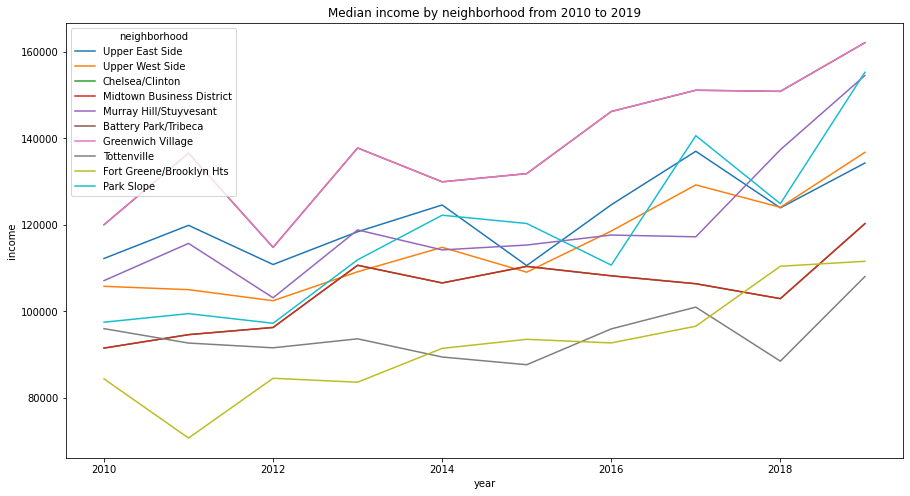

In [ ]:
neighborhood_change = income_df[income_df['neighborhood'].isin(top10neighborhood['neighborhood'])]
plt.figure(figsize=(15,8))
plt.title('Median income by neighborhood from 2010 to 2019')
sns.lineplot(data=neighborhood_change, x='year', y='income', hue='neighborhood')
plt.show()

**Bottom 10 Neighborhoods**

Below are the bottom 10 neighborhoods with the lowest median income as of 2019. 

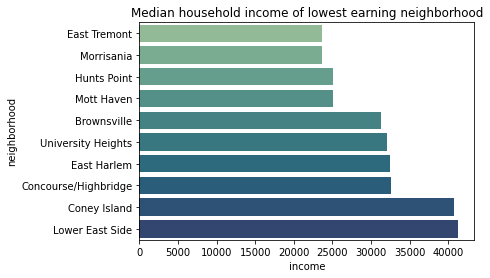

In [ ]:
bot10neighborhood = income_df[income_df['year']==2019].sort_values(by='income', ascending=True, ignore_index=True).head(10)
sns.barplot(data=bot10neighborhood, x='income',y='neighborhood', palette='crest').set_title('Median household income of lowest earning neighborhood')
plt.show()

The disparity between the top 10 and bottom 10 neighborhoods is immense. How has the median income changed over the past ten years for the bottom 10 neighborhoods?

Although some neighborhoods have fared marginally better from 2010 to 2019, the trends are much flatter, and even negative in some cases, compared to that of the top 10 neighborhoods.

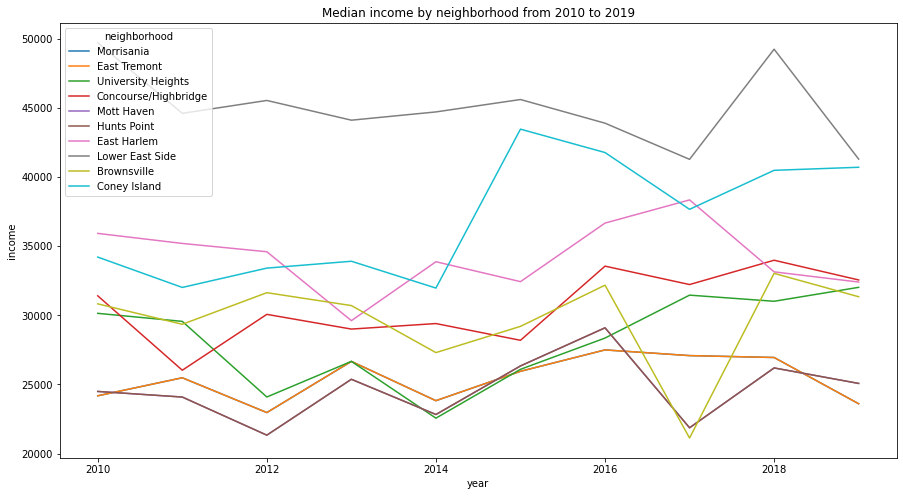

In [ ]:
neighborhood_change = income_df[income_df['neighborhood'].isin(bot10neighborhood['neighborhood'])]
plt.figure(figsize=(15,8))
plt.title('Median income by neighborhood from 2010 to 2019')
sns.lineplot(data=neighborhood_change, x='year', y='income', hue='neighborhood')
plt.show()

It will be interesting to see how this income disparity factors into our Airbnb analysis.

### LA Income Data

In [ ]:
la_income = pd.read_csv('/content/drive/Shareddrives/CIS545: AirBnB/Data/Median_Household_Income_by_Census_Tract.csv')
census_map = pd.read_csv('/content/drive/Shareddrives/CIS545: AirBnB/Data/Census_Tract_Locations__LA_.csv')

#### First Glance and Cleaning

Unlike the NYC income data, we needed to preprocess our LA income data a bit. Although we also collected median incomes, we couldn't obtain it by neighborhood; instead, we have median incomes by tracts. Consequently, we also obtained a mapping between tract locations and neighborhoods to better integrate the incomes for our purposes.

In [ ]:
la_income.head(5)

,OBJECTID,CT10,OID,tract,B19013e1,B19013Ae1,B19013Be1,B19013Ce1,B19013De1,B19013Ee1,B19013Fe1,B19013Ge1,B19013He1,B19013Ie1,ShapeSTArea,ShapeSTLength
0,1,911001,2254,911001,50732,50640,0,0,0,0,47750,0,50518,49107,4.025736e+09,353933.808192
1,2,980003,2319,980003,0,0,0,0,0,0,0,0,0,0,2.078690e+09,273188.863210
2,3,930301,2316,930301,75313,83000,0,0,0,0,0,0,83833,0,1.111802e+10,628603.531323
3,4,573003,1869,573003,63182,75516,0,0,50750,0,62857,125938,75938,62857,4.824002e+06,9050.008458
4,5,297602,986,297602,65729,65208,0,0,112763,0,50313,0,68068,51196,6.697031e+06,12308.315385


In [ ]:
census_map.head(5)

,GEOID,Tract,Tract Number,Neighborhood,Location,Latitude,Longitude
0,1400000US06037101110,"Census Tract 1011.10, Los Angeles County, Cali...",101110,Tujunga,"(34.2595555, -118.293602)",34.259555,-118.293602
1,1400000US06037101122,"Census Tract 1011.22, Los Angeles County, Cali...",101122,Tujunga,"(34.267357, -118.29024)",34.267357,-118.290240
2,1400000US06037101210,"Census Tract 1012.10, Los Angeles County, Cali...",101210,Tujunga,"(34.251998, -118.2926875)",34.251998,-118.292687
3,1400000US06037101220,"Census Tract 1012.20, Los Angeles County, Cali...",101220,Tujunga,"(34.2511895, -118.281014)",34.251190,-118.281014
4,1400000US06037101300,"Census Tract 1013, Los Angeles County, California",101300,Tujunga,"(34.2455945, -118.271731)",34.245595,-118.271731


Using information from the data source, we know what the relevant columns are in our main income. Let's limit the data to just these first.

In [ ]:
la_income = la_income[['tract', 'B19013e1']]
la_income.columns = ['tract', 'income']

census_map = census_map[['Tract Number', 'Neighborhood']]
census_map.columns = ['tract', 'neighborhood'] 

Looking at the datatypes, we can see that everything looks good! No casting or formatting is necessary in this regard.

In [ ]:
la_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344 entries, 0 to 2343
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   tract   2344 non-null   int64
 1   income  2344 non-null   int64
dtypes: int64(2)
memory usage: 36.8 KB


In [ ]:
census_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344 entries, 0 to 2343
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tract         2344 non-null   int64 
 1   neighborhood  2344 non-null   object
dtypes: int64(1), object(1)
memory usage: 36.8+ KB


Now we'll map each tract to the corresponding neighborhood to obtain a dataset consistent with the rest of our datasets.

In [ ]:
la_income_neighborhood = la_income.merge(census_map,left_on='tract', right_on='tract').drop(columns='tract')

Let's look at what we have. Hmmm, from the get-go we can see that we could be missing data. Leaving these as zero could significantly impact our analysis so let's see what we can do with it.

In [ ]:
la_income_neighborhood.head(5)

,income,neighborhood
0,50732,Southeast Antelope Valley
1,0,Northeast Antelope Valley
2,75313,Angeles Crest
3,63182,Long Beach
4,65729,San Pedro


Let's take a look at "Northeast Antelope Valley".

In [ ]:
la_income_neighborhood[la_income_neighborhood['neighborhood'] == 'Northeast Antelope Valley']

,income,neighborhood
1,0,Northeast Antelope Valley
171,44643,Northeast Antelope Valley
190,54012,Northeast Antelope Valley
2187,45897,Northeast Antelope Valley
2198,47078,Northeast Antelope Valley
2247,25938,Northeast Antelope Valley


Because each neighborhood maps to multiple tracts, we should be fine to drop zeroes since we need to average the incomes of each tract to obtain a general approximation of income per neighborhood. 

In [ ]:
# Drop all tract regions with 0 income
la_income_neighborhood = la_income_neighborhood[la_income_neighborhood.income!=0]

# Aggregate income on neighborhood level
la_income_neighborhood = la_income_neighborhood.groupby('neighborhood').mean().reset_index()

In [ ]:
la_income_neighborhood.head(5)

,neighborhood,income
0,Acton,102877.500000
1,Adams-Normandie,34859.600000
2,Agoura Hills,130459.666667
3,Agua Dulce,84048.000000
4,Alhambra,59975.250000


#### Let's Explore!

Now that our data is filtered and cleaned, we want to get a better understanding of what neighborhood dynamics are like between the 250+ neighborhoods.

Our exploration is more limited because we don't have year-over-year data. The only data we have is from 2018.

**Top 10 Neighborhoods**

Below are the top 10 neighborhoods with the highest median income as of 2018. 

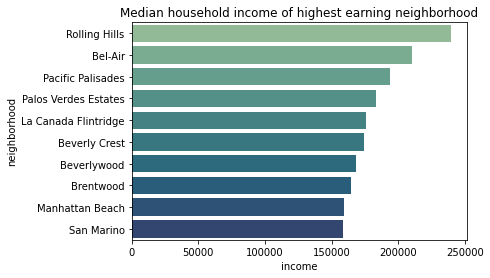

In [ ]:
top10neighborhood = la_income_neighborhood.sort_values(by='income', ascending=False, ignore_index=True).head(10)
sns.barplot(data=top10neighborhood, x='income',y='neighborhood', palette='crest').set_title('Median household income of highest earning neighborhood')
plt.show()

**Bottom 10 Neighborhoods**

Below are the bottom 10 neighborhoods with the lowest median income as of 2018. 

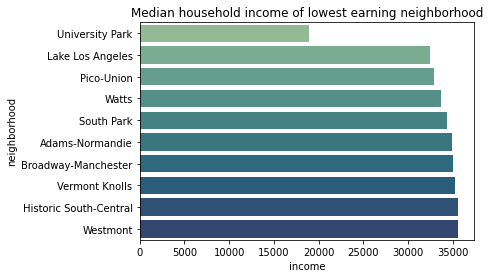

In [ ]:
bot10neighborhood = la_income_neighborhood.sort_values(by='income', ascending=True, ignore_index=True).head(10)
sns.barplot(data=bot10neighborhood, x='income',y='neighborhood', palette='crest').set_title('Median household income of lowest earning neighborhood')
plt.show()

Just at a glance, we can see the disparities in income are even more immense than those of top 10 and bottom 10 neighborhoods in NYC.

# Data Integration

Now we are finally ready to integrate all of our datasets.